In [0]:
# default_exp data.exploratory.se.metrics

# Exploration of your data

> This module comprises some of the statistical and inference techniques to describe the inner properties of software data. The submodules might include:
>
> - Descriptive statistics
> - Software Metrics
> - Information Theory
> - Learning Principels Detection (Occams' Razor, Biased data, and Data Snooping)
> - Inference: Probabilistic and Causal

### Specifically in this module

> - Cyclomatic complexity (CYCLO)
> - Coupling Between Objects (CBO)
> - Lack of Cohesion of Methods 5 (LCOM5)
> - Top/Least 20 Occurring Tokens
> - Percentage of redundancy (just Java)
> - How many Type I and Type II clones are in Java datasets?

In [0]:
# #hide
# from nbdev.showdoc import *

In [3]:
!pip install sentencepiece
# !pip install metrics # Outdated Cyclomatic Complexity tool
!pip install lizard
!pip install tree_sitter

In [0]:
# export
# Imports
import pandas as pd
import sentencepiece as sp
from numpy import mean, std
from statistics import median
from scipy.stats import sem, t
import lizard
import matplotlib.pyplot as plt
from tree_sitter import Language, Parser

# TODO: Remove when mongo call is implemented
import os

In [5]:
!git clone https://github.com/tree-sitter/tree-sitter-c
# !git clone https://github.com/tree-sitter/tree-sitter-cpp
!git clone https://github.com/tree-sitter/tree-sitter-java
# !git clone https://github.com/tree-sitter/tree-sitter-javascript
# !git clone https://github.com/tree-sitter/tree-sitter-python

fatal: destination path 'tree-sitter-c' already exists and is not an empty directory.
fatal: destination path 'tree-sitter-java' already exists and is not an empty directory.


In [0]:
# TODO: Replace with actual mongo call
def simulate_getting_dataframes_from_mongo():
    corpus_data = {"system": [], "name": [], "ground_truth": [], "contents": []}
    path = "./source_code"
    for file in os.listdir(path):
        if not os.path.isdir(os.path.join(path, file)):
            corpus_data["system"].append(None)
            corpus_data["name"].append(file)
            corpus_data["ground_truth"].append("src")
            try:
                with open (os.path.join(path, file), "r", encoding='utf-8') as f:
                    corpus_data['contents'].append(f.read())
            except UnicodeDecodeError:
                with open (os.path.join(path, file), "r", encoding='iso-8859-15') as f:
                    corpus_data['contents'].append(f.read())
    corpus_df = pd.DataFrame(data = corpus_data)
    return corpus_df

In [0]:
# export
def add_length_col(df, col, length_col_name='length'):
    """Adds a length column with the length of entries in the specified column of a dataframe"""
    df[length_col_name] = df[col].astype(str).apply(len)
    return df

In [0]:
# export
def add_mccabe_metrics(df, col):
    """Adds information about function length and cyclomatic complexity to the corpus dataframe"""
    # TODO: calculate metrics per class instead of per file
    file_ccn = []
    file_nloc = []
    num_funcs = []
    avg_func_ccn = []
    avg_func_nloc = []
    # avg_func_tok_count = [] # TODO: Figure out how lizard tokenizes
    for i in range(len(df)):
        metrics = lizard.analyze_file.analyze_source_code(df["name"][i], df["contents"][i])
        file_ccn.append(metrics.CCN)
        file_nloc.append(metrics.nloc)
        num_funcs.append(len(metrics.function_list))
        avg_func_ccn.append(metrics.average_cyclomatic_complexity)
        avg_func_nloc.append(metrics.average_nloc)
        # avg_func_tok_count.append(metrics.average_token_count) # TODO: Figure out how lizard tokenizes
    df["file_ccn"] = file_ccn
    df["file_nloc"] = file_nloc
    df["num_funcs"] = num_funcs
    df["avg_func_ccn"] = avg_func_ccn
    df["avg_func_nloc"] = avg_func_nloc
    # df["avg_func_tok_count"] = avg_func_tok_count # TODO: Figure out how lizard tokenizes
    return df

In [0]:
#export
def create_parser_builds(path=None):
    """Creates a dictionary of tree-sitter parsers for select languages"""
    Language.build_library(
        # Store the library in the `build` directory
        'build/my-languages.so',

        # Include one or more languages
        [
            'tree-sitter-c',
            # 'tree-sitter-cpp',
            'tree-sitter-java',
            # 'tree-sitter-javascript',
            # 'tree-sitter-python'
        ]
    )

    C_LANGUAGE = Language('build/my-languages.so', 'c')
    # CPP_LANGUAGE = Language('build/my-languages.so', 'cpp')
    JAVA_LANGUAGE = Language('build/my-languages.so', 'java')
    # JS_LANGUAGE = Language('build/my-languages.so', 'javascript')
    # PY_LANGUAGE = Language('build/my-languages.so', 'python')
    
    return {'c':C_LANGUAGE, 'java':JAVA_LANGUAGE}

In [0]:
#export
def parsing_keywords():
    class Keywords:
        def __init__(self):
            self.java = {"class": "class_declaration", "method":"method_declaration", "attribute": "field_declaration"}

        def for_lang(self, extension):
            if extension == 'java':
                return self.java
    return Keywords()

In [0]:
#export
def class_attributes_c(class_node, text):
    return 0

In [0]:
#export
def class_methods_c(class_node, file_text):
    return 0

In [0]:
#export
def distinct_class_attribute_calls_c(class_node, atts, file_text):
    return 0

In [0]:
#export
def find_class_nodes(root_node, node_name):
    class_list = []
    def rec_node_search(node):
        if node.type == "class_declaration":
            class_list.append(node)
        else:
            for child in node.children:
                rec_node_search(child)
    rec_node_search(root_node)
    return class_list

In [0]:
#export
def class_attributes_java(class_node, file_text):
    """Finds the fields/attributes for a class AST"""
    # TODO: Determine if this is rigourous enough for all files
    class_attributess = []
    for a in range(len(class_node.children)):
        if class_node.children[a].type == "class_body":
            class_body = class_node.children[a]
            for b in range(len(class_body.children)):
                if class_body.children[b].type == "field_declaration":
                    field_dec = class_body.children[b]
                    for c in range(len(field_dec.children)):
                        if field_dec.children[c].type == "variable_declarator":
                            var_dec = field_dec.children[c]
                            for d in range(len(var_dec.children)):
                                if var_dec.children[d].type == "identifier":
                                    word = ""
                                    for i in range(var_dec.children[d].start_byte, var_dec.children[d].end_byte):
                                        word += file_text[i]
                                    class_attributess.append(word)
    return class_attributess

In [0]:
#export
def class_methods_java(class_node, file_text):
    """Counts the number of methods for each class in a sample of java code"""
    class_methods = []
    for a in range(len(class_node.children)):
        if class_node.children[a].type == "class_body":
            class_body = class_node.children[a]
            for b in range(len(class_body.children)):
                if class_body.children[b].type == "method_declaration":
                    meth_dec = class_body.children[b]
                    for c in range(len(meth_dec.children)):
                        if meth_dec.children[c].type == "identifier":
                            word = ""
                            for i in range(meth_dec.children[c].start_byte, meth_dec.children[c].end_byte):
                                word += file_text[i]
                            class_methods.append(word)
    return class_methods

In [0]:
#export
def find_string_in_file(node, pattern, file_text):
    """Counts the number of occurences of a pattern in a sample of code"""
    # TODO: Optomize this by making it stop searching after finding the first occurence
    if len(node.children) > 0:
        count = 0
        for i in node.children:
            count += find_string_in_file(i, pattern, file_text)
        return count
    else:
        word = ""
        for i in range(node.start_byte, node.end_byte):
            try:
                word += file_text[i]
            except IndexError:
                print("Pattern was:", pattern)
                print("Word was:", word)
                print("Start byte was:", node.start_byte)
                print("End byte was:", node.end_byte)
                print("File length was:", len(file_text))
        if word == pattern:
            # print(f"Found. Start byte: {node.start_point}, end byte: {node.end_point}")
            return 1
        else:
            return 0

In [0]:
#export
def distinct_class_attribute_calls_java(class_node, attributes, file_text):
    """Counts the sum of distinct attribute calls per method per class in code"""
    total_distinct_att_calls = 0
    for a in range(len(class_node.children)):
        if class_node.children[a].type == "class_body":
            class_body = class_node.children[a]
            for b in range(len(class_body.children)):
                if class_body.children[b].type == "method_declaration":
                    distinct_attribute_calls = 0
                    for attribute in attributes:
                        if find_string_in_file(class_body.children[b], attribute, file_text):
                            distinct_attribute_calls += 1
                    total_distinct_att_calls += distinct_attribute_calls
    return total_distinct_att_calls

In [0]:
#export
def calculate_lcom5(tree, extension, file_text, name):
    """Parses the syntax tree of code to calculate the LCOM5 of its classes"""
    attribute_func_dict = {'c':class_attributes_c, 'java':class_attributes_java}
    methods_func_dict = {'c':class_methods_c, 'java':class_methods_java}
    distinct_att_calls_func_dict = {'c':distinct_class_attribute_calls_c, 'java':distinct_class_attribute_calls_java}
    keywords = parsing_keywords()
    root_node = tree.root_node
    
    if extension not in attribute_func_dict:
        print(f"Tried to get LCOM5 of file with extension '.{extension}', that language is not supported, 0 assigned to column.")
        return [0]
    class_nodes = find_class_nodes(root_node, keywords.for_lang(extension)["class"])
    attributes = []
    methods = []
    dist_attribute_calls = []
    for i in range(len(class_nodes)):
        attributes.append(attribute_func_dict[extension](class_nodes[i], file_text))
        methods.append(methods_func_dict[extension](class_nodes[i], file_text))
        dist_attribute_calls.append(distinct_att_calls_func_dict[extension](class_nodes[i], attributes[i], file_text))
    lcom5_list = []
    for j in range(len(class_nodes)):
        num_atts = len(attributes[j])
        num_meths = len(methods[j])
        num_DAC = dist_attribute_calls[j]
        numerator = num_DAC - (num_meths*num_atts)
        denominator = num_atts - (num_meths*num_atts)
        if denominator == 0:
            lcom5_list.append("Undefined")
        else:
            lcom5_list.append(numerator/denominator)
    return lcom5_list
        

In [0]:
#export
def add_lcom5(df, col):
    """Adds a column with the LCOM5 of each class of each file to a dataframe"""
    lang_builds = create_parser_builds()
    parser = Parser()
    file_lcom5 = []
    for i in range(len(df)):
        ext = df["name"][i].split('.')[-1]
        parser.set_language(lang_builds[ext])
        tree = parser.parse(bytes(df["contents"][i], "utf8"))
        file_lcom5.append(calculate_lcom5(tree, ext, df["contents"][i], df["name"][i]))
    df["file_lcom5"] = file_lcom5
    return df

In [0]:
#export
def flatten_list_of_lists(list_list):
    """Takes in a list of lists and flattens it, returning a list of each entry"""
    flattened_list = []
    for sublist in list_list:
        for entry in sublist:
            flattened_list.append(entry)
    return flattened_list

In [0]:
# export
def display_numeric_col_stats(col, conf = 0.95, sig_figs = 4, clean=True):
    """Computes statistical metrics about the entries in a dataframe column or list"""
    numeric_types = [int, float, complex]
    if clean: col = [x for x in col if type(x) in numeric_types]

    print("Min =", round(min(col), sig_figs))
    print("Max =", round(max(col), sig_figs))
    print("Average =", round(mean(col), sig_figs))
    print("Median =", round(median(col), sig_figs))
    print("Standard Deviation =", round(std(col), sig_figs))
    
    n = len(col)
    m = mean(col)
    std_err = sem(col)
    h = std_err * t.ppf((1 + conf) / 2, n - 1)

    start = m - h
    end = m + h
    print(f"{conf} of data points fall between {round(start, sig_figs)} and {round(end, sig_figs)}")

In [0]:
#export
def display_numeric_col_hist(col, col_name="measure", num_bins=None, clean=True):
    """Displays a histogram with a customized number of bins for the data in a specified dataframe column or list"""
    numeric_types = [int, float, complex]
    if clean: col = [x for x in col if type(x) in numeric_types]
    
    rng = max(col) - min(col)
    num = len(col)
    stnd_dev = std(col)
    # num_bins = round((rng*(pow(num,1/3)))/(3.49*stnd_dev)) # Bins calculated according to https://academic.oup.com/biomet/article-abstract/66/3/605/232642
    if not num_bins:
        num_bins = 20
    plt.hist(col, num_bins, color="blue", alpha=0.5, edgecolor="black", linewidth=1.0)
    plt.title(col_name + " Histogram")
    plt.ylabel("Value Occurrences")
    plt.xlabel(col_name)
    plt.show()

# Analysis & Visualization

In [24]:
# Retrieve the data
corpus_df = simulate_getting_dataframes_from_mongo()
total_file_count = len(corpus_df)
print("Total files:", total_file_count)

Total files: 151


In [0]:
# Add the new metric columns to the corpus dataframe
corpus_df = add_length_col(corpus_df, 'contents', 'code_length')

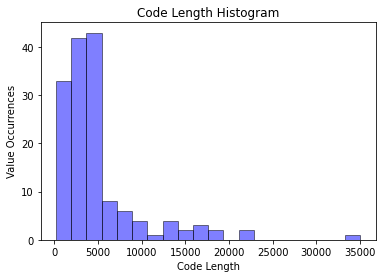

Min = 221
Max = 35035
Average = 4874.8344
Median = 3707
Standard Deviation = 4910.8254
0.95 of data points fall between 4082.5612 and 5667.1077


In [26]:
# Print statistical information about the length of each file
display_numeric_col_hist(corpus_df['code_length'], "Code Length")
display_numeric_col_stats(corpus_df['code_length'])

In [0]:
# Add the new metric columns to the corpus dataframe
corpus_df = add_mccabe_metrics(corpus_df, 'contents')

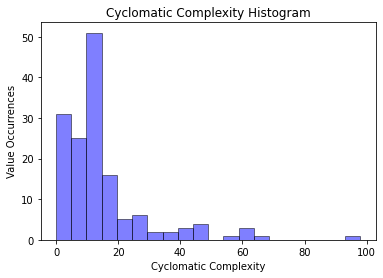

Min = 0
Max = 98
Average = 14.6093
Median = 11
Standard Deviation = 15.0571
0.95 of data points fall between 12.1801 and 17.0385


In [28]:
# Print statistical information about the cyclomatic complexity per file
display_numeric_col_hist(corpus_df['file_ccn'], "Cyclomatic Complexity")
display_numeric_col_stats(corpus_df['file_ccn'])

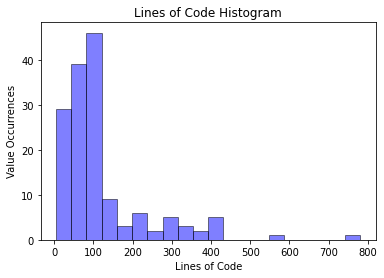

Min = 5
Max = 781
Average = 118.8543
Median = 85
Standard Deviation = 116.3206
0.95 of data points fall between 100.0881 and 137.6205


In [29]:
# Print statistical information about the number of lines of code per file
display_numeric_col_hist(corpus_df['file_nloc'], "Lines of Code")
display_numeric_col_stats(corpus_df['file_nloc'])

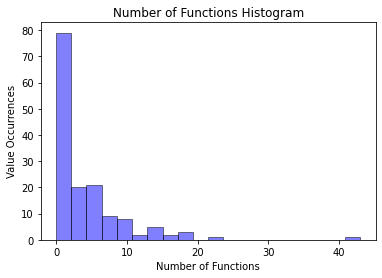

Min = 0
Max = 43
Average = 4.7483
Median = 2
Standard Deviation = 5.2225
0.95 of data points fall between 3.9058 and 5.5909


In [30]:
# Print statistical information about the number of functions per file
display_numeric_col_hist(corpus_df['num_funcs'], "Number of Functions")
display_numeric_col_stats(corpus_df['num_funcs'])

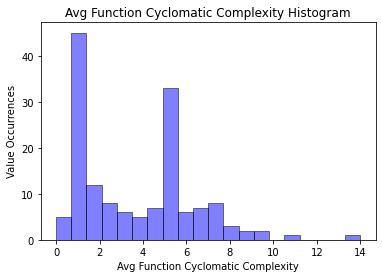

Min = 0.0
Max = 14.0
Average = 3.6855
Median = 3.4706
Standard Deviation = 2.6547
0.95 of data points fall between 3.2572 and 4.1138


In [31]:
# Print statistical information about the average function cyclomatic complexities per file
display_numeric_col_hist(corpus_df['avg_func_ccn'], "Avg Function Cyclomatic Complexity")
display_numeric_col_stats(corpus_df['avg_func_ccn'])

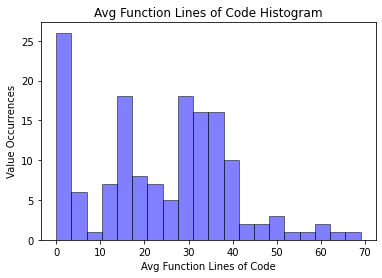

Min = 0.0
Max = 69.0
Average = 23.9674
Median = 24.75
Standard Deviation = 15.4246
0.95 of data points fall between 21.4789 and 26.4559


In [32]:
# Print statistical information about the average function cyclomatic complexity per file
display_numeric_col_hist(corpus_df['avg_func_nloc'], "Avg Function Lines of Code")
display_numeric_col_stats(corpus_df['avg_func_nloc'])

In [0]:
# Add the new metric columns to the corpus dataframe
corpus_df = add_lcom5(corpus_df, 'contents')

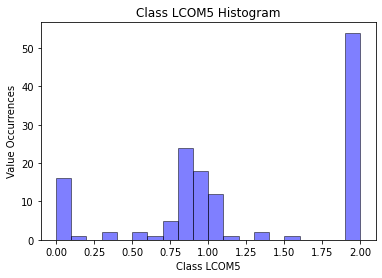

Min = 0.0
Max = 2.0
Average = 1.2177
Median = 1.0
Standard Deviation = 0.6939
0.95 of data points fall between 1.1009 and 1.3345


In [34]:
# # Print statistical information about the average LCOM5 per file
display_numeric_col_hist(flatten_list_of_lists(corpus_df['file_lcom5']), "Class LCOM5")
display_numeric_col_stats(flatten_list_of_lists(corpus_df['file_lcom5']))

In [35]:
pd.set_option('display.expand_frame_repr', False)
corpus_df.head(30)

,system,name,ground_truth,contents,code_length,file_ccn,file_nloc,num_funcs,avg_func_ccn,avg_func_nloc,file_lcom5
0,None,ServletUpdateTeaching.java,src,package smos.application.teachingManagement;\n...,4229,14,100,2,7.000000,40.000000,[2.0]
1,None,ServletLoadTeachingList.java,src,package smos.application.reportManagement;\n\n...,3958,10,91,2,5.000000,34.000000,[2.0]
2,None,ServletLoadYear.java,src,package smos.application.userManagement;\n\nim...,3563,11,82,2,5.500000,32.000000,[2.0]
3,None,DBConnection.java,src,/*\n * DBConnection\n *\n */\n\npackage smos.s...,5966,15,114,5,3.000000,16.000000,[1.5]
4,None,ServletShowUserTeachingForm.java,src,package smos.application.userManagement;\n\nim...,4281,12,90,2,6.000000,33.000000,[2.0]
5,None,RicercaAddebiti.java,src,package interfacce;\nimport java.awt.*;\nimpor...,6335,16,169,6,2.666667,24.666667,[0.828125]
6,None,VediPrenotazione.java,src,package interfacce;\nimport java.awt.*;\nimpor...,979,4,33,2,2.000000,10.000000,[Undefined]
7,None,ServletShowTeacherTeachingFormByClass.java,src,package smos.application.userManagement;\n\nim...,4025,10,87,2,5.000000,33.000000,[2.0]
8,None,ServletRemoveStudentClassroom.java,src,package smos.application.userManagement;\n\nim...,4024,15,92,2,7.500000,34.500000,[Undefined]
9,None,ServletInsertUser.java,src,package smos.application.userManagement;\n\nim...,4780,16,103,2,8.000000,42.000000,[2.0]


In [0]:
# pd.set_option('display.expand_frame_repr', False)
# corpus_df

In [0]:
# https://github.com/priv-kweihmann/multimetric
# The above link is another possible tool to easily calculate code metrics for various languages

In [0]:
# https://books.google.com/books?id=DxuGi5h2-HEC&pg=PA140&lpg=PA140&dq=do+header+files+in+c+have+a+cyclomatic+complexity&source=bl&ots=0WxxjeX9rR&sig=ACfU3U1QnoKnwrsj4YbSQxATeaoYMvBWwg&hl=en&sa=X&ved=2ahUKEwijtqKxhJXoAhUSXa0KHctQD38Q6AEwAnoECAkQAQ#v=onepage&q=do%20header%20files%20in%20c%20have%20a%20cyclomatic%20complexity&f=false
# The abover link goes to an article discussing cyclomatic complexity and c header files

In [0]:
# http://site.iugaza.edu.ps/mroos/files/Software-Metrics1.pdf
# The above link is a pdf that explains every LCOM metric

In [0]:
# https://hal.inria.fr/hal-00646878/file/Duca11b-Cutter-deliverable11-SoftwareMetrics.pdf
# Another good article about the cohesion metrics among others

# Scratch Code (Testing)

In [1]:
def test():
    a = 1

l = []
l.append(test())
print(l)

[None]


In [0]:
Language.build_library(
    # Store the library in the `build` directory
    'build/my-languages.so',

    # Include one or more languages
    [
        'tree-sitter-c',
        # 'tree-sitter-cpp',
        'tree-sitter-java',
        # 'tree-sitter-javascript',
        # 'tree-sitter-python'
    ]
)

C_LANGUAGE = Language('build/my-languages.so', 'c')
# CPP_LANGUAGE = Language('build/my-languages.so', 'cpp')
JAVA_LANGUAGE = Language('build/my-languages.so', 'java')
# JS_LANGUAGE = Language('build/my-languages.so', 'javascript')
# PY_LANGUAGE = Language('build/my-languages.so', 'python')

lang_builds = {'c':C_LANGUAGE, 'java':JAVA_LANGUAGE}

parser = Parser()
ext = 'java'
parser.set_language(lang_builds[ext])
test_df = simulate_getting_dataframes_from_mongo()
tree = parser.parse(bytes(test_df["contents"][0], "utf8"))

In [0]:
# root_node = tree.root_node
# text = test_df["contents"][0]
# for a in range(len(root_node.children)):
#     if root_node.children[a].type == "class_declaration":
#         class_dec = root_node.children[a]
#         for b in range(len(class_dec.children)):
#             if class_dec.children[b].type == "class_body":
#                 class_body = class_dec.children[b]
#                 for c in range(len(class_body.children)):
#                     if class_body.children[c].type == "field_declaration":
#                         field_dec = class_body.children[c]
#                         for d in range(len(field_dec.children)):
#                             if field_dec.children[d].type == "variable_declarator":
#                                 # word = ""
#                                 # for i in range(var_dec.children[e].start_byte, var_dec.children[d].end_byte):
#                                 #     word += text[i]
#                                 # print(word)
#                                 var_dec = field_dec.children[d]
#                                 for e in range(len(var_dec.children)):
#                                     if var_dec.children[e].type == "identifier":
#                                         word = ""
#                                         for i in range(var_dec.children[e].start_byte, var_dec.children[e].end_byte):
#                                             word += text[i]
#                                         print(word)
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print(text)

In [46]:
print(test_df["contents"][0])

package interfacce;
import java.awt.*;
import java.awt.event.*;
import common.utility.*;
import common.def.*;
import java.util.Date;
import moduli.*;

public class RicercaAddebiti extends Frame 
{  
    
    //Dichiarazioni di variabili
    Panel panel1, panel2, panel3;
    Label  etichetta1, label1, label3;
    List lista;
    Button  Annulla, Cerca;
    TextField stanza;
    GridBagLayout gridbag = new GridBagLayout();
	Frame padre = new Frame();
    Frame figlio;
    ListaAddebiti L;
    Addebito add;
    float totale_add;
    
    public RicercaAddebiti(Frame p)
    {
        super("Ricerca degli addebiti");
        padre = p;
        padre.setEnabled(false);
        setupPanels();
        init();
        pack();
        setVisible(true); 
    }
                     
        void setupPanels()
        {  
			this.setFont(ConfigurazioneSistema.font_base);
            //Creo due pulsanti  
            Annulla = new Button(" Fine  ");
            Cerca = new Button(" Cerca ");

      

In [0]:

def find_string_in_file(node, pattern, text):
    if len(node.children) > 0:
        count = 0
        for i in node.children:
            count += find_string_in_file(i, pattern, text)
        return count
    else:
        word = ""
        for i in range(node.start_byte, node.end_byte):
            # print(text[i], end="")
            word += text[i]
        # print()
        if word == pattern:
            print(f"Found. Start byte: {node.start_point}, end byte: {node.end_point}")
            return 1
        else:
            return 0
node = tree.root_node
num_found = find_string_in_file(node, "p", test_df["contents"][1])
print(num_found)

Found. Start byte: (10, 14), end byte: (10, 15)
Found. Start byte: (17, 8), end byte: (17, 9)
Found. Start byte: (26, 19), end byte: (26, 20)
Found. Start byte: (33, 69), end byte: (33, 70)
4


In [0]:
query = JAVA_LANGUAGE.query("""
(binary_expression
    left: ("etichetta")
""")

captures = query.captures(tree.root_node)

SyntaxError: ignored

In [0]:
assert len(captures) == 2
assert captures[0][0] == function_name_node
assert captures[0][1] == "function.def"

In [0]:
cursor = tree.walk()
print(cursor.node.type)
cursor.goto_next_sibling
cursor

program


In [0]:
print(cursor.node.type)
print(cursor.goto_first_child)

program


In [0]:
!pip install multimetric

     |████████████████████████████████| 921kB 6.8MB/s 
  Created wheel for multimetric: filename=multimetric-1.1.3-cp36-none-any.whl size=20170 sha256=0d755e6c6634a50c74264bff0a29dab99642f5051bf7c6ad1c2d3d637a2b1403
  Stored in directory: /root/.cache/pip/wheels/6d/c7/81/52b4323f26674931ea81e0d7589a71081e05e88426004c5331
Successfully built multimetric
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: Pygments 2.1.3
    Uninstalling Pygments-2.1.3:
      Successfully uninstalled Pygments-2.1.3


In [0]:
import multimetric

In [0]:
multimetric.rea

In [0]:
if 0:
    print("Hey")

In [0]:
print(round(1236721.8237468732, 3))

1236721.824


In [0]:
!pip install lizard

In [0]:
import subprocess
import json
def add_lizard_mccabe_metrics(df, col):
    mccabe = []
    sloc = []
    comments = []
    ratio = []
    for i in range(len(df)):
        if i == 99:
            print("At file #100", end="")
        if ((i + 1) % 200) == 0:
            print(", file #" + str(i + 1), end="")
        ext = df["file_name"][i].split('.')[-1]
        if ext == 'h':
            ext = 'c'
        with open(f"temp_file.{ext}", "w", encoding='UTF-8') as fp:
            fp.write(df[col][i])
        out = subprocess.Popen(['metrics', '-q', '--format=json', f"temp_file.{ext}"], 
                               stdout=subprocess.PIPE, 
                               stderr=subprocess.STDOUT)
        stdout,stderr = out.communicate()
        metrics_data = json.loads(stdout)
        mccabe.append(metrics_data['files'][f"temp_file.{ext}"]['mccabe'])
        sloc.append(metrics_data['files'][f"temp_file.{ext}"]['sloc'])
        comments.append(metrics_data['files'][f"temp_file.{ext}"]['comments'])
        ratio.append(metrics_data['files'][f"temp_file.{ext}"]['ratio_comment_to_code'])
#         print(mccabe_data['files'][f'temp_file.{LANGUAGE}'].keys())
        os.remove(f"temp_file.{ext}")
    df["complexity"] = mccabe
    df["code_lines"] = sloc
    df["comments"] = comments
    df["ratio_comment_to_code"] = ratio
    return df

In [0]:
!lizard source_code/est.c

  NLOC    CCN   token  PARAM  length  location  
------------------------------------------------
       7      1     35      2      11 est_logger_stderr@9-19@source_code/est.c
      11      2     53      2      16 est_log_msg@27-42@source_code/est.c
      14      3     66      3      24 est_log@46-69@source_code/est.c
      18      2    154      1      23 printStackTrace@73-95@source_code/est.c
      18      5     91      1      31 est_log_backtrace@99-129@source_code/est.c
       3      1      9      1       3 est_get_version@136-138@source_code/est.c
       3      1      9      1       3 est_get_api_level@148-150@source_code/est.c
       7      2     43      1       9 est_log_version@156-164@source_code/est.c
      10      2     46      2      16 est_init_logger@181-196@source_code/est.c
       4      1     11      1       4 est_enable_backtrace@213-216@source_code/est.c
      42      9    202      3      52 est_read_x509_request@239-290@source_code/est.c
      29      5    135     

In [0]:
!metrics source_code/est.c

Metrics Summary:
Files                       Language        SLOC Comment McCabe 
----- ------------------------------ ----------- ------- ------ 
    1                         Python           9       0      3 
----- ------------------------------ ----------- ------- ------ 
    1                          Total           9       0      3 


In [0]:
import lizard

In [0]:
i = lizard.analyze_file("source_code/est.c")

In [0]:
print(i.CCN)

204


In [0]:
print(i.__dict__)

{'filename': 'source_code/est.c', 'nloc': 1005, 'function_list': [<lizard.FunctionInfo object at 0x7f137fc5fc18>, <lizard.FunctionInfo object at 0x7f137fc5fd68>, <lizard.FunctionInfo object at 0x7f137fc5fb00>, <lizard.FunctionInfo object at 0x7f137fc5ff28>, <lizard.FunctionInfo object at 0x7f137fc5ff98>, <lizard.FunctionInfo object at 0x7f137fc5ffd0>, <lizard.FunctionInfo object at 0x7f137fc5f978>, <lizard.FunctionInfo object at 0x7f137fc6b898>, <lizard.FunctionInfo object at 0x7f137fc6b080>, <lizard.FunctionInfo object at 0x7f137fc6b0f0>, <lizard.FunctionInfo object at 0x7f137fc6b160>, <lizard.FunctionInfo object at 0x7f137fc6b128>, <lizard.FunctionInfo object at 0x7f137fc6b2b0>, <lizard.FunctionInfo object at 0x7f137fc6b208>, <lizard.FunctionInfo object at 0x7f137fc6b3c8>, <lizard.FunctionInfo object at 0x7f137fc6b470>, <lizard.FunctionInfo object at 0x7f137fc6b550>, <lizard.FunctionInfo object at 0x7f137fc6b5c0>, <lizard.FunctionInfo object at 0x7f137fc6b668>, <lizard.FunctionInfo o

In [0]:
for i in range(len(i.function_list)):
  

SyntaxError: ignored

In [0]:
print(i.function_list[0].__dict__)

{'cyclomatic_complexity': 3, 'nloc': 8, 'token_count': 35, 'name': 'func', 'long_name': 'func( )', 'start_line': 1, 'end_line': 10, 'parameters': [], 'filename': 'thing.py', 'top_nesting_level': 0, 'length': 10, 'fan_in': 0, 'fan_out': 0, 'general_fan_out': 0}


In [0]:
print(len(i.function_list))

37


In [0]:
i

In [0]:
!metrics thing.py

Metrics Summary:
Files                       Language        SLOC Comment McCabe 
----- ------------------------------ ----------- ------- ------ 
    1                         Python          32       0      9 
----- ------------------------------ ----------- ------- ------ 
    1                          Total          32       0      9 


In [0]:
thing = lizard.analyze_file("thing.py")
print(thing.__dict__)
print(thing.CCN)
for i in range(len(thing.function_list)):
    print(thing.function_list[i].__dict__)


{'filename': 'thing.py', 'nloc': 32, 'function_list': [<lizard.FunctionInfo object at 0x7f47bee93198>, <lizard.FunctionInfo object at 0x7f47bee932e8>, <lizard.FunctionInfo object at 0x7f47bee933c8>, <lizard.FunctionInfo object at 0x7f47bee93630>, <lizard.FunctionInfo object at 0x7f47bee935f8>, <lizard.FunctionInfo object at 0x7f47bee93400>], 'token_count': 145}
12
{'cyclomatic_complexity': 1, 'nloc': 2, 'token_count': 10, 'name': '__init__', 'long_name': '__init__( self )', 'start_line': 5, 'end_line': 6, 'parameters': ['self'], 'filename': 'thing.py', 'top_nesting_level': 1, 'length': 2, 'fan_in': 0, 'fan_out': 0, 'general_fan_out': 0}
{'cyclomatic_complexity': 1, 'nloc': 2, 'token_count': 10, 'name': '__init__', 'long_name': '__init__( self )', 'start_line': 9, 'end_line': 10, 'parameters': ['self'], 'filename': 'thing.py', 'top_nesting_level': 2, 'length': 2, 'fan_in': 0, 'fan_out': 0, 'general_fan_out': 0}
{'cyclomatic_complexity': 1, 'nloc': 2, 'token_count': 10, 'name': 'delete',

In [0]:
thing.filename

'source_code/est.c'

In [0]:
thing.nloc

1005

In [0]:
print(thing.functions_average)

<bound method FileInformation.functions_average of <lizard.FileInformation object at 0x7f5ed935c978>>


In [0]:
i = lizard.analyze_file.analyze_source_code("AllTests.cpp", "int foo(){}")

In [0]:
i.__dict__

{'filename': 'AllTests.cpp',
 'function_list': [<lizard.FunctionInfo at 0x7f137fbacc18>],
 'nloc': 1,
 'token_count': 6}

In [0]:
i.CCN

1

In [0]:
lizard.analyze_file.analyze_source_code("AllTests.py", "def foo():\n\tif (True): \n\tprint('HI')").CCN

2

In [0]:
import subprocess
import json
def add_mccabe_metrics(df, col):
    mccabe = []
    sloc = []
    comments = []
    ratio = []
    for i in range(len(df)):
        if i == 99:
            print("At file #100", end="")
        if ((i + 1) % 200) == 0:
            print(", file #" + str(i + 1), end="")
        ext = df["file_name"][i].split('.')[-1]
        if ext == 'h':
            ext = 'c'
        with open(f"temp_file.{ext}", "w", encoding='UTF-8') as fp:
            fp.write(df[col][i])
        out = subprocess.Popen(['metrics', '-q', '--format=json', f"temp_file.{ext}"], 
                               stdout=subprocess.PIPE, 
                               stderr=subprocess.STDOUT)
        stdout,stderr = out.communicate()
        metrics_data = json.loads(stdout)
        mccabe.append(metrics_data['files'][f"temp_file.{ext}"]['mccabe'])
        sloc.append(metrics_data['files'][f"temp_file.{ext}"]['sloc'])
        comments.append(metrics_data['files'][f"temp_file.{ext}"]['comments'])
        ratio.append(metrics_data['files'][f"temp_file.{ext}"]['ratio_comment_to_code'])
#         print(mccabe_data['files'][f'temp_file.{LANGUAGE}'].keys())
        os.remove(f"temp_file.{ext}")
    df["complexity"] = mccabe
    df["code_lines"] = sloc
    df["comments"] = comments
    df["ratio_comment_to_code"] = ratio
    return df